In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

In [2]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

xgb_train_df = pd.read_csv(r'rendered_data/xgbregressor_train_submission.csv', index_col=0)
lgbm_train_df = pd.read_csv(r'rendered_data/lgbmregressor_train_submission.csv', index_col=0)
cat_train_df = pd.read_csv(r'rendered_data/catregressor_train_submission.csv', index_col=0)
lassocv_train_df = pd.read_csv(r'rendered_data/lassocvregressor_train_submission.csv', index_col=0)

xgb_test_df = pd.read_csv(r'rendered_data/xgbregressor_test_submission.csv', index_col=0)
lgbm_test_df = pd.read_csv(r'rendered_data/lgbmregressor_test_submission.csv', index_col=0)
cat_test_df = pd.read_csv(r'rendered_data/catregressor_test_submission.csv', index_col=0)
lassocv_test_df = pd.read_csv(r'rendered_data/lassocvregressor_test_submission.csv', index_col=0)

In [3]:
regressors = [
    'xgbregressor', 
    'lgbmregressor', 
    'catregressor', 
    #'lassocvregressor',
    #'tfregressor',
]

In [4]:
features = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction','HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'BusinessTravel_v', 'Department_v', 'EducationField_v','Gender_v', 'JobRole_v', 'MaritalStatus_v', 'OverTime_v']
target = ['Attrition']

In [5]:
# Join oof preds
oof_df = pd.DataFrame(index=np.arange(len(train_df.index)))
for i in regressors:
    df = pd.read_csv(f"rendered_data/{i}_train_submission.csv", index_col=0)
    df.rename(columns={"Attrition": i}, inplace=True)
    oof_df = pd.concat([oof_df,df], axis=1)
    
# Join test preds
test_preds = pd.DataFrame()
for i in regressors:
    df = pd.read_csv(f"rendered_data/{i}_test_submission.csv", index_col=0)
    df.rename(columns={"Attrition": i}, inplace=True)
    test_preds = pd.concat([test_preds,df], axis=1)
    
oof_df.head(3)

,xgbregressor,lgbmregressor,catregressor
0,0.376262,0.065280,0.078111
1,0.362073,0.029312,-0.000738
2,0.340472,0.013582,-0.007162


In [6]:
oof_df.describe()

,xgbregressor,lgbmregressor,catregressor
count,1677.000000,1677.000000,1677.000000
mean,0.363048,0.048003,0.046845
std,0.010844,0.026669,0.046070
min,0.338372,0.008307,-0.053823
25%,0.356711,0.029954,0.014568
50%,0.362768,0.043046,0.036228
75%,0.367916,0.056572,0.080861
max,0.418991,0.186467,0.294524


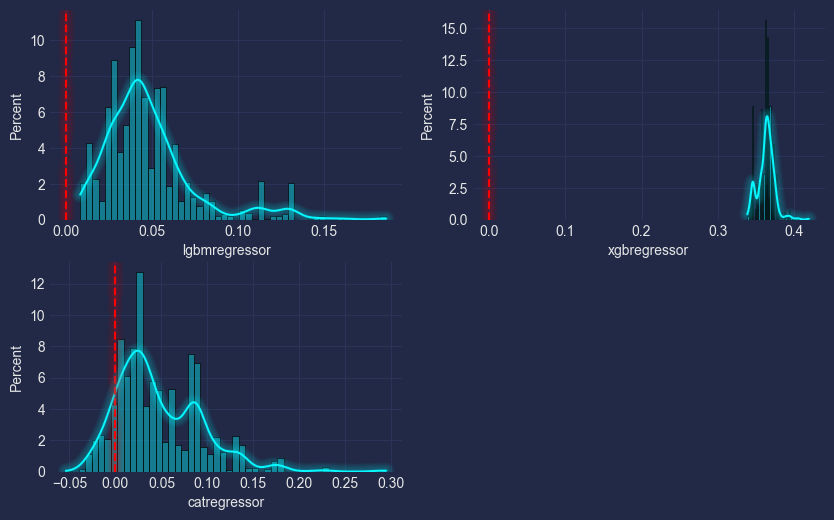

In [25]:
import math
plt.style.use("cyberpunk")
features = oof_df.columns

n_cols = 2
n_rows = math.ceil(len(features) / n_cols)
cell_with_dim = 5
cell_height_dim = 3

histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
    a.axis('off')


for i, column in enumerate(oof_df.columns):
    
    row = math.ceil(i / n_cols) - 1
    col = (i % n_cols)
    
    sns.histplot(oof_df[column], **histplot_hyperparams, ax=ax[row, col])
    ax[row, col].axvline(x = 0, color = 'r', linestyle='--')
    mplcyberpunk.make_lines_glow(ax[row, col])


plt.show()

In [26]:
features

Index(['catregressor', 'xgbregressor', 'lgbmregressor'], dtype='object')

In [27]:
ax

array([[<AxesSubplot: xlabel='lgbmregressor', ylabel='Percent'>,
        <AxesSubplot: xlabel='xgbregressor', ylabel='Percent'>],
       [<AxesSubplot: xlabel='catregressor', ylabel='Percent'>,
        <AxesSubplot: >]], dtype=object)

In [28]:
# Evaluate oof preds
scores = {}
for col in oof_df.columns:
    scores[col] = roc_auc_score(train_df[target], oof_df[col])

# Sort scores
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

# Sort oof_df and test_preds
oof_df = oof_df[list(scores.keys())]
test_preds = test_preds[list(scores.keys())]

scores

{'catregressor': 0.7872088693297224,
 'xgbregressor': 0.7734546377792823,
 'lgbmregressor': 0.7566536899119838}

In [29]:
#MODELS['tfregressor'] = MODELS['tfregressor'].astype('float')

In [30]:
# Initialise
STOP = False
current_best_ensemble = oof_df.iloc[:,0].copy()
current_best_test_preds = test_preds.iloc[:,0].copy()
MODELS = oof_df.iloc[:,0:].copy()
history = []
history_names = []
i=0

# Hill climbing
while not STOP:
    i+=1
    potential_new_best_cv_score = roc_auc_score(train_df[target], current_best_ensemble)
    k_best, wgt_best = None, None
    for k in MODELS:
        for wgt in np.arange(-0.5,0.51,0.01):
            potential_ensemble = (1-wgt) * current_best_ensemble + wgt * MODELS[k]
            cv_score = roc_auc_score(train_df[target], potential_ensemble)
            if cv_score > potential_new_best_cv_score:
                potential_new_best_cv_score = cv_score
                k_best, wgt_best = k, wgt
            
    if k_best is not None:
        current_best_ensemble = (1-wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
        current_best_test_preds = (1-wgt_best) * current_best_test_preds + wgt_best * test_preds[k_best]
        MODELS.drop(k_best, axis=1, inplace=True)
        if MODELS.shape[1]==0:
            STOP = True
        print(f'Iteration: {i}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}')
        history_names.append(k_best)
        history.append(potential_new_best_cv_score)
    else:
        STOP = True

Iteration: 1, Model added: xgbregressor, Best weight: 0.50, Best AUC: 0.79352
Iteration: 2, Model added: catregressor, Best weight: -0.45, Best AUC: 0.79968
Iteration: 3, Model added: lgbmregressor, Best weight: 0.02, Best AUC: 0.79971


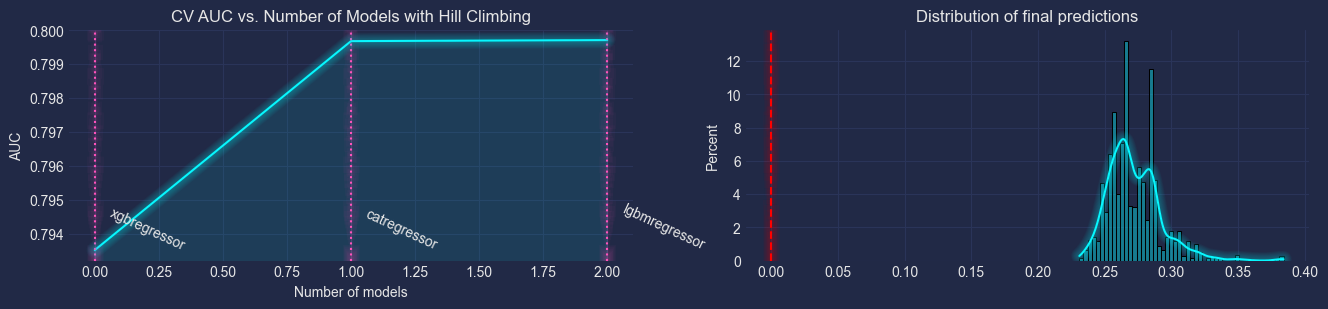

In [31]:
plt.style.use("cyberpunk")

n_cols = 2
n_rows = 1
cell_with_dim = 8
cell_height_dim = 3

histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
sns.lineplot(history, ax=ax[0])
sns.histplot(current_best_test_preds, **histplot_hyperparams, ax=ax[1])

ylim = ax[0].get_ylim()

for i, auc in enumerate(history):
    ax[0].axvline(x = i, color = '#FE53BB', linestyle=':')
    ax[0].text(i + 0.05, ylim[0] + ((ylim[0] - ylim[1] ) * -0.05), history_names[i], fontsize=10, rotation=-25)

ax[0].set_ylim(ylim)


ax[1].axvline(x = 0, color = 'r', linestyle='--')

mplcyberpunk.make_lines_glow(ax[0])
mplcyberpunk.add_underglow(ax[0])
mplcyberpunk.make_lines_glow(ax[1])

ax[0].set_title("CV AUC vs. Number of Models with Hill Climbing")
ax[0].set_xlabel("Number of models")
ax[0].set_ylabel("AUC")
ax[1].set_title("Distribution of final predictions")


plt.show()

In [32]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2', '3', '4']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        #sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [13]:
model_list = oof_df.iloc[:,0:].copy()

for reg in regressors:
    train_df[reg] = model_list[reg]

In [14]:
train_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,xgbregressor,lgbmregressor,catregressor
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,2,3,10,0,7,8,0,0.376262,0.065280,0.078111
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,3,3,4,2,0,3,0,0.362073,0.029312,-0.000738
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,3,3,3,2,1,2,0,0.340472,0.013582,-0.007162
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,1,1,6,0,0,2,0,0.371043,0.046158,0.077308
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,0,3,31,14,4,10,1,0.373750,0.128402,0.136560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,Female,...,2,4,10,0,0,8,0,0.373673,0.053366,0.076452
1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,Male,...,3,4,4,2,1,3,0,0.362073,0.043584,0.029614
1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,Male,...,2,3,1,0,0,0,1,0.382197,0.121914,0.175508


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

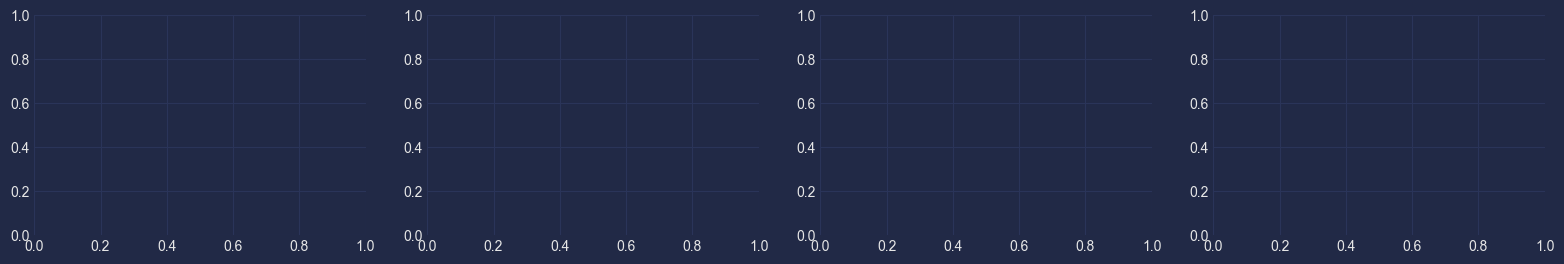

In [15]:
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0]] + regressors)

In [ ]:
[target[0]]+regressors

In [ ]:
# Submit predictions
submission = sub.copy()
submission["Attrition"] = current_best_test_preds.values
submission.to_csv("submission.csv", index=True)